# MNIST classification example with TensorFlow

## Install packages on Google  Cloud Datalab (locally use conda env)
### Select in the Python3 Kernel:
In the menu bar the of 'Kernel', select   
**python3**
### Install needed packages
copy the command below in a Google Cloud Datalab cell  
**!pip install tensorflow==1.12**
### Restart the Kernel 
this is to take into account the new installed packages. Click in the menu bar on:  
**Reset Session**

## Needed librairies

In [429]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import gzip
import sys
import _pickle as cPickle
import shutil
import glob
import re
import os
import codecs
import json 
import subprocess
import requests
import google.auth

In [27]:
print(tf.__version__)
print(tf.keras.__version__)

1.12.0
2.1.6-tf


In [28]:
tf.logging.set_verbosity(tf.logging.INFO)

## Import the Data

In [29]:
# get mnist data, split between train and test sets
# on GCP
#(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# with AXA network
def load_data(path):
    f = gzip.open(path, 'rb')
    if sys.version_info < (3,):
        data = cPickle.load(f)
    else:
        data = cPickle.load(f, encoding='bytes')
    f.close()
    return data
(x_train, y_train), (x_test, y_test) = load_data(path='../data/mnist.pkl.gz')

In [30]:
# check data shape (training)
x_train.shape

(60000, 28, 28)

In [31]:
# check data shape (train)
x_test.shape

(10000, 28, 28)

In [32]:
x_train.dtype, x_test.dtype

(dtype('uint8'), dtype('uint8'))

In [33]:
np.max(x_train), np.min(x_train), np.max(x_test), np.min(x_test)  

(255, 0, 255, 0)

In [34]:
x_test.nbytes/1024.0**2

7.476806640625

In [35]:
x_train.nbytes/1024.0**2

44.86083984375

In [36]:
y_test.nbytes/1024.0**2

0.0095367431640625

In [37]:
y_train.nbytes/1024.0**2

0.057220458984375

## Normalize and reorganize the data

In [38]:
# cast uint8 -> float32
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [39]:
# renormalize the data 255 grey variation
x_train /= 255
x_test /= 255

In [40]:
# reshape the data 28 x 28 -> 784
x_train = x_train.reshape(len(x_train), x_train.shape[1]*x_train.shape[2])
x_test = x_test.reshape(len(x_test), x_test.shape[1]*x_test.shape[2])

In [41]:
x_train.shape

(60000, 784)

In [42]:
x_test.shape

(10000, 784)

## Reshape the labels

In [43]:
y_train.shape

(60000,)

In [44]:
y_test.shape

(10000,)

In [45]:
np.unique(y_train), np.unique(y_test)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8))

In [46]:
num_classes = len(np.unique(y_train))
num_classes

10

In [47]:
# convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [48]:
y_train.shape

(60000, 10)

In [49]:
y_test.shape

(10000, 10)

In [50]:
dim_input=x_train.shape[1]
dim_input

784

## Visualize the data

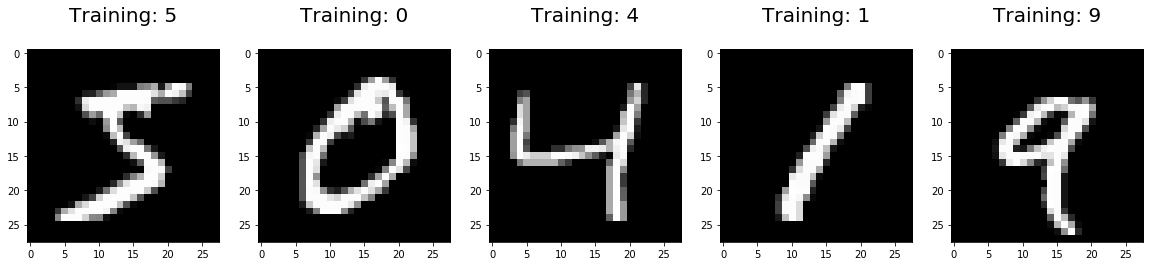

In [51]:
plt.figure(figsize=(20,4))
for index, (image, label) in enumerate(zip(x_train[0:5], y_train[0:5])):
    plt.subplot(1, 5, index + 1)
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
    plt.title('Training: %i\n' % np.argmax(label), fontsize = 20)

## Defined some hyperparameters

In [52]:
# learning rate
learning_rate = 0.5

# number of epoch to train our model
EPOCHS = 2

# size of our mini batch
#BATCH_SIZE = len(x_train)
BATCH_SIZE = 128

# shuffle buffer size
SHUFFLE_BUFFER_SIZE = 10 * BATCH_SIZE

# prefetch buffer size
PREFETCH_BUFFER_SIZE = 1 #tf.contrib.data.AUTOTUNE

# number of paralell calls
NUM_PARALELL_CALL = 4

# hidden layer 1
n1=300

## Defined flags

In [53]:
def del_all_flags(FLAGS):
    flags_dict = FLAGS._flags()    
    keys_list = [keys for keys in flags_dict]    
    for keys in keys_list:
        FLAGS.__delattr__(keys)
    
del_all_flags(tf.flags.FLAGS)

In [54]:
tf.app.flags.DEFINE_string('f', '', 'kernel') # just for jupyter notebook and avoir : "UnrecognizedFlagError: Unknown command line flag 'f'"
tf.app.flags.DEFINE_string('model_dir', '../results/Models/Mnist/tf_1_12/estimator/ckpt/', 'Dir to save a model and checkpoints')
tf.app.flags.DEFINE_string('saved_dir', '../results/Models/Mnist/tf_1_12/estimator/pt/', 'Dir to save a model for TF serving')
tf.app.flags.DEFINE_string('model_dir_keras', '../results/Models/Mnist/tf_1_12/keras/ckpt/', 'Dir to save a model and checkpoints with keras')
tf.app.flags.DEFINE_string('tensorboard_dir_keras', '../results/Models/Mnist/tf_1_12/keras/logs/', 'Dir to save logs for TensorBoard with keras')
tf.app.flags.DEFINE_integer('shuffle_buffer_size', SHUFFLE_BUFFER_SIZE , 'Shuffle buffer size')
tf.app.flags.DEFINE_integer('prefetch_buffer_size', PREFETCH_BUFFER_SIZE, 'Prefetch buffer size')
tf.app.flags.DEFINE_integer('batch_size', BATCH_SIZE, 'Batch size')
tf.app.flags.DEFINE_integer('epoch', EPOCHS, 'number of epoch')
tf.app.flags.DEFINE_integer('num_parallel_calls', NUM_PARALELL_CALL, 'Number of paralell calls')
FLAGS = tf.app.flags.FLAGS

In [55]:
print(FLAGS)


/Users/tarrade/anaconda3/envs/env_gcp_dl/lib/python3.6/site-packages/ipykernel_launcher.py:
  --batch_size: Batch size
    (default: '128')
    (an integer)
  --epoch: number of epoch
    (default: '2')
    (an integer)
  --f: kernel
    (default: '')
  --model_dir: Dir to save a model and checkpoints
    (default: '../results/Models/Mnist/tf_1_12/estimator/ckpt/')
  --model_dir_keras: Dir to save a model and checkpoints with keras
    (default: '../results/Models/Mnist/tf_1_12/keras/ckpt/')
  --num_parallel_calls: Number of paralell calls
    (default: '4')
    (an integer)
  --prefetch_buffer_size: Prefetch buffer size
    (default: '1')
    (an integer)
  --saved_dir: Dir to save a model for TF serving
    (default: '../results/Models/Mnist/tf_1_12/estimator/pt/')
  --shuffle_buffer_size: Shuffle buffer size
    (default: '1280')
    (an integer)
  --tensorboard_dir_keras: Dir to save logs for TensorBoard with keras
    (default: '../results/Models/Mnist/tf_1_12/keras/logs/')

absl

## tf.data.Dataset
https://www.tensorflow.org/guide/performance/datasets  
To summarize, one good order for the different transformations is:
- create the dataset
- shuffle (with a big enough buffer size https://stackoverflow.com/questions/46444018/meaning-of-buffer-size-in-dataset-map-dataset-prefetch-and-dataset-shuffle)
- repeat
- map with the actual work (preprocessing, augmentation…) using multiple parallel calls
- batch
- prefetch

ModeKeys:  
https://www.tensorflow.org/api_docs/python/tf/estimator/ModeKeys  
- EVAL
- PREDICT
- TRAIN

In [56]:
tf.estimator.ModeKeys.EVAL, tf.estimator.ModeKeys.PREDICT, tf.estimator.ModeKeys.TRAIN

('eval', 'infer', 'train')

In [57]:
def input_dataset_fn(x_data, y_data, batch_size=128, mode=tf.estimator.ModeKeys.TRAIN):
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        tf.logging.info("input_dataset_fn: PREDICT, {}".format(mode))
    elif mode == tf.estimator.ModeKeys.EVAL:
        tf.logging.info("input_dataset_fn: EVAL, {}".format(mode))
    elif mode == tf.estimator.ModeKeys.TRAIN:
        tf.logging.info("input_dataset_fn: TRAIN, {}".format(mode))
    
    # 1) convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((x_data, y_data))
    
    # 2) shuffle (with a big enough buffer size)    :        
    if mode == tf.estimator.ModeKeys.TRAIN:
        #num_epochs = None # loop indefinitely
        num_epochs = FLAGS.epoch
        dataset = dataset.shuffle(buffer_size=FLAGS.shuffle_buffer_size, seed=2)# depends on sample size
    else:
        #num_epochs = 1 # end-of-input after this
        num_epochs = FLAGS.epoch
        
    print('the number of epoch: num_epoch =', num_epochs)
        
    # caching data
    #dataset = dataset.cache()
    
    # 3) automatically refill the data queue when empty
    dataset = dataset.repeat(num_epochs)
    
    # 4) map
    #dataset = dataset.map(map_func=parse_fn, num_parallel_calls=FLAGS.num_parallel_calls)

    # 5) create batches of data
    dataset = dataset.batch(batch_size=batch_size, drop_remainder=True)
    
    # 6) prefetch data for faster consumption, based on your system and environment, allows the tf.data runtime to automatically tune the prefetch buffer sizes
    dataset = dataset.prefetch(FLAGS.prefetch_buffer_size)

    return dataset

In [58]:
training_dataset = input_dataset_fn(x_train, 
                                    y_train, 
                                    mode=tf.estimator.ModeKeys.TRAIN, 
                                    batch_size=FLAGS.batch_size)
testing_dataset = input_dataset_fn(x_test, 
                                   y_test,
                                   mode=tf.estimator.ModeKeys.EVAL, 
                                   batch_size=len(x_test))

INFO:tensorflow:input_dataset_fn: TRAIN, train
the number of epoch: num_epoch = 2
INFO:tensorflow:input_dataset_fn: EVAL, eval
the number of epoch: num_epoch = 2


### Exploration dataset API

In [59]:
iterator = training_dataset.make_one_shot_iterator()

In [60]:
# next_element
features, labels = iterator.get_next()

In [61]:
n=0
# maximum: EPOCHS*len(x_train)//BATCH_SIZE
n_iter=10
with tf.Session() as sess:
    while True:
        try:
            start_time = time.clock()
            x,y = sess.run([features, labels])
            print('iteration n:', n, 'execution time:', time.clock() - start_time, 'seconds')
            print(x.shape)
            print(y.shape)
            print('first label of the batch',np.argmax(y[0]),'\n')
            n+=1
            if n>=n_iter:
                print('number of iteration reached')
                break
        except tf.errors.OutOfRangeError:
            print('tf.errors.OutOfRangeError')
            break

iteration n: 0 execution time: 19.241626999999998 seconds
(128, 784)
(128, 10)
first label of the batch 9 

iteration n: 1 execution time: 0.004407000000000494 seconds
(128, 784)
(128, 10)
first label of the batch 2 

iteration n: 2 execution time: 0.0030760000000000787 seconds
(128, 784)
(128, 10)
first label of the batch 6 

iteration n: 3 execution time: 0.0047330000000016526 seconds
(128, 784)
(128, 10)
first label of the batch 1 

iteration n: 4 execution time: 0.004023999999994032 seconds
(128, 784)
(128, 10)
first label of the batch 5 

iteration n: 5 execution time: 0.004402999999996382 seconds
(128, 784)
(128, 10)
first label of the batch 1 

iteration n: 6 execution time: 0.004941000000002305 seconds
(128, 784)
(128, 10)
first label of the batch 9 

iteration n: 7 execution time: 0.004837000000001979 seconds
(128, 784)
(128, 10)
first label of the batch 8 

iteration n: 8 execution time: 0.005237000000001046 seconds
(128, 784)
(128, 10)
first label of the batch 2 

iteration 

In [62]:
iterator = testing_dataset.make_one_shot_iterator()

In [63]:
# next_element
features, labels = iterator.get_next()

In [64]:
with tf.Session() as sess:
    while True:
        try:
            start_time = time.clock()
            x,y = sess.run([features, labels])
            print(time.clock() - start_time, 'seconds')
            print(x.shape)
            print(y.shape)
            print('first label of the batch',np.argmax(y[0]),'\n')
        except tf.errors.OutOfRangeError:
            print('tf.errors.OutOfRangeError')
            break

3.4615380000000044 seconds
(10000, 784)
(10000, 10)
first label of the batch 7 

0.1018100000000004 seconds
(10000, 784)
(10000, 10)
first label of the batch 7 

tf.errors.OutOfRangeError


## Machine Learning modelling with Keras
### Build the model

In [65]:
FLAGS.model_dir_keras

'../results/Models/Mnist/tf_1_12/keras/ckpt/'

In [66]:
shutil.rmtree(FLAGS.model_dir_keras, ignore_errors=True)

In [67]:
def baseline_model(opt='tf'):
    # create model
    model = tf.keras.Sequential()
 
    # hidden layer
    model.add(tf.keras.layers.Dense(dim_input, 
                    input_dim=dim_input, 
                    kernel_initializer=tf.keras.initializers.he_normal(),
                    bias_initializer=tf.keras.initializers.Zeros(),
                    activation='relu'))
    # last layer
    model.add(tf.keras.layers.Dense(num_classes, 
                    kernel_initializer=tf.keras.initializers.he_normal(),
                    bias_initializer=tf.keras.initializers.Zeros(),
                    activation='softmax'))
    
    # weight initialisation
    # He: keras.initializers.he_normal(seed=None)
    # Xavier: keras.initializers.glorot_uniform(seed=None)
    # Radom Normal: keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
    # Truncated Normal: keras.initializers.TruncatedNormal(mean=0.0, stddev=0.05, seed=None)
    
    if opt=='keras':
        optimiser=tf.keras.optimizers.Adam(lr=0.01, beta_1=0.9)
        # GD/SGC:   keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
        # Adam:     keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
        # RMSProp:  keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
        # Momentum: keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.0, nesterov=False)
    else:
        #optimiser (use tf.train and not tf.keras to use MirrorStrategy)
        # https://www.tensorflow.org/api_docs/python/tf/train/Optimizer
        optimiser=tf.train.AdamOptimizer(learning_rate=0.001, beta1=0.9)
        # GD/SGC:   tf.train.GradientDescentOptimizer(learning_rate, use_locking=False, name='GradientDescent') 
        # Adam:     tf.train.AdamOptimizer(learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-08, use_locking=False,name='Adam')
        # RMSProp:  tf.train.RMSPropOptimizer(learning_rate, decay=0.9, momentum=0.0, epsilon=1e-10, use_locking=False, centered=False, name='RMSProp')
        # Momentum: tf.train.MomentumOptimizer(learning_rate, momentum, use_locking=False, name='Momentum', use_nesterov=False)
    
    # Compile model
    model.compile(loss='categorical_crossentropy', 
                  optimizer=optimiser, 
                  metrics=['accuracy'])
    return model

In [68]:
# reset the model
tf.keras.backend.clear_session()

In [69]:
# build the model
# keras optimiser
model_opt_keras = baseline_model(opt='keras')

### Check the nuber of parameters

In [70]:
model_opt_keras.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 784)               615440    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                7850      
Total params: 623,290
Trainable params: 623,290
Non-trainable params: 0
_________________________________________________________________


### Check input and output layer names

In [71]:
model_opt_keras.input_names # Use this name as the dictionary key in the TF input function

['dense_input']

In [72]:
model_opt_keras.output_names

['dense_1']

## Call back with Keras

### Print info during iterations

In [73]:
class UDFPrint(tf.keras.callbacks.Callback):
    def __init__(self, test_data):
        self.test_data = test_data
        
    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        _, __, x_train, y_train = self.test_data
        loss_train, acc_train = self.model.evaluate(x_train, y_train, verbose=0)
        print('Reached epoch {0:3d} cost J = {1:.5f}'.format(epoch, loss_train))
        return

    def on_epoch_end(self, epoch, logs={}):
        x_test, y_test, x_train, y_train = self.test_data
        loss_train, acc_train = self.model.evaluate(x_train, y_train, verbose=0)
        loss_test, acc_test = self.model.evaluate(x_test, y_test, verbose=0)
        print(' accurary on the training set {0:.4f}'.format(acc_train))
        print(' accurary on the testing set {0:.4f}'.format(acc_test))

    def on_batch_begin(self, batch, logs={}):
        #print('  ---> starting minibatch', batch)
        return

    def on_batch_end(self, batch, logs={}):
        #print('  ---> ending minibatch', batch)
        return
return

### TensorBoard

In [74]:
FLAGS.tensorboard_dir_keras

'../results/Models/Mnist/tf_1_12/keras/logs/'

In [75]:
for file in glob.glob(FLAGS.tensorboard_dir_keras+'*'):
    print(re.findall(r'[^\\/]+|[\\/]',file)[-1])

events.out.tfevents.1549038093.Fabien-Tarrades-MacBook-Pro.local
events.out.tfevents.1549050335.Fabien-Tarrades-MacBook-Pro.local
events.out.tfevents.1549038351.Fabien-Tarrades-MacBook-Pro.local
events.out.tfevents.1549050551.Fabien-Tarrades-MacBook-Pro.local


In [76]:
shutil.rmtree(FLAGS.tensorboard_dir_keras+'*' ,ignore_errors=True)

In [77]:
#keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=32, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None, update_freq='epoch')
tbCallBack=tf.keras.callbacks.TensorBoard(log_dir=FLAGS.tensorboard_dir_keras, 
                                          histogram_freq=1, 
                                          write_graph=True)

## Store the original weights

In [78]:
initial_weights = model_opt_keras.get_weights()

## Training and inference using Keras
https://www.tensorflow.org/guide/keras
- batch_size 
  determines the number of samples in each mini batch. Its maximum is the number of all samples, which makes gradient descent accurate, the loss will decrease towards the minimum if the learning rate is small enough, but iterations are slower. Its minimum is 1, resulting in stochastic gradient descent: Fast but the direction of the gradient step is based only on one example, the loss may jump around. batch_size allows to adjust between the two extremes: accurate gradient direction and fast iteration. Also, the maximum value for batch_size may be limited if your model + data set does not fit into the available (GPU) memory.
- steps_per_epoch 
  the number of batch iterations before a training epoch is considered finished. If you have a training set of fixed size you can ignore it but it may be useful if you have a huge data set or if you are generating random data augmentations on the fly, i.e. if your training set has a (generated) infinite size. If you have the time to go through your whole training data set I recommend to skip this parameter.
- validation_steps 
  similar to steps_per_epoch but on the validation data set instead on the training data. If you have the time to go through your whole validation data set I recommend to skip this parameter.



### Fit the model using Keras

In [79]:
# Set to the original weights for testing other pipelines
model_opt_keras.set_weights(initial_weights)

# Fit the model
hist=model_opt_keras.fit(x_train, # use batch_size
                         y_train, # use batch_size
                         validation_data=(x_test, y_test), # use full validation step at the end of each epoch
                         callbacks=[UDFPrint((x_test, y_test, x_train, y_train)), tbCallBack],
                         epochs=EPOCHS, 
                         batch_size=BATCH_SIZE,
                         verbose=2)

Train on 60000 samples, validate on 10000 samples
Reached epoch   0 cost J = 2.35535
Epoch 1/2
 accurary on the training set 0.9626
 accurary on the testing set 0.9548
 - 104s - loss: 0.2118 - acc: 0.9360 - val_loss: 0.1453 - val_acc: 0.9548
Reached epoch   1 cost J = 0.11518
Epoch 2/2
 accurary on the training set 0.9798
 accurary on the testing set 0.9725
 - 103s - loss: 0.1113 - acc: 0.9668 - val_loss: 0.1078 - val_acc: 0.9725


In [80]:
print(hist.history)

{'val_loss': [0.14530197284817695, 0.107827948564291], 'val_acc': [0.9548, 0.9725], 'loss': [0.21180632532636326, 0.11132152475019295], 'acc': [0.9359500000317892, 0.9667666666348775]}


### Evaluate the model using Keras

In [81]:
score = model_opt_keras.evaluate(x_test, 
                                 y_test, 
                                 verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.10782794496663846
Test accuracy: 0.9725


In [82]:
score = model_opt_keras.evaluate(x_train, 
                                 y_train, 
                                 verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

Train loss: 0.06794429655395409
Train accuracy: 0.97975


### Save the model using Keras

In [83]:
# with keras optimiser we can save the model+weight
if not os.path.exists(FLAGS.model_dir_keras):
    os.makedirs(FLAGS.model_dir_keras)
model_opt_keras.save(FLAGS.model_dir_keras+'keras_model.h5')

### Reload the model and make evaluation using Keras

In [84]:
reload_model_opt_keras=tf.keras.models.load_model(FLAGS.model_dir_keras+'keras_model.h5')

In [85]:
score = reload_model_opt_keras.evaluate(x_train, 
                                        y_train, 
                                        verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

Train loss: 0.06794429655395409
Train accuracy: 0.97975


### Monitoring using TensorBoard

## Training and inference using  Keras and tf.data.dataset

- **batch_size** determines the number of samples in each mini batch. Its maximum is the number of all samples, which makes gradient descent accurate, the loss will decrease towards the minimum if the learning rate is small enough, but iterations are slower. Its minimum is 1, resulting in stochastic gradient descent: Fast but the direction of the gradient step is based only on one example, the loss may jump around. batch_size allows to adjust between the two extremes: accurate gradient direction and fast iteration. Also, the maximum value for batch_size may be limited if your model + data set does not fit into the available (GPU) memory.
- **steps_per_epoch** the number of batch iterations before a training epoch is considered finished. If you have a training set of fixed size you can ignore it but it may be useful if you have a huge data set or if you are generating random data augmentations on the fly, i.e. if your training set has a (generated) infinite size. If you have the time to go through your whole training data set I recommend to skip this parameter.
- **validation_steps** similar to steps_per_epoch but on the validation data set instead on the training data. If you have the time to go through your whole validation data set I recommend to skip this parameter.



In [86]:
print('number of events:', len(x_train))
print('number of epoch:', EPOCHS)
print('number of batch size:', BATCH_SIZE)
print('number of batches per epoch:', len(x_train) // BATCH_SIZE)
print('number of BATCH_SIZE*len(x_train) // BATCH_SIZE*', BATCH_SIZE*(len(x_train) // BATCH_SIZE) )

number of events: 60000
number of epoch: 2
number of batch size: 128
number of batches per epoch: 468
number of BATCH_SIZE*len(x_train) // BATCH_SIZE* 59904


In [87]:
print('number of events:', len(x_test))
print('number of epoch:', EPOCHS)
print('number of batch size:', BATCH_SIZE)
print('number of batches per epoch:', len(x_test) // BATCH_SIZE)
print('number of BATCH_SIZE*len(x_train) // BATCH_SIZE*', BATCH_SIZE*(len(x_test) // BATCH_SIZE) )

number of events: 10000
number of epoch: 2
number of batch size: 128
number of batches per epoch: 78
number of BATCH_SIZE*len(x_train) // BATCH_SIZE* 9984


### Fit the model using Keras and tf.data.dataset

In [88]:
# Set to the original weights for testing other pipelines
model_opt_keras.set_weights(initial_weights)

# Fit the model (using data.Dataset)
hist=model_opt_keras.fit(training_dataset.make_one_shot_iterator(), # use batch_size
                         steps_per_epoch=len(x_train) // BATCH_SIZE,
                         validation_data=testing_dataset.make_one_shot_iterator(), # use full validation dataset
                         validation_steps=1, 
                         callbacks=[UDFPrint((x_test, y_test, x_train, y_train)), tbCallBack],
                         epochs=EPOCHS,
                         verbose = 2)

Reached epoch   0 cost J = 2.35535
Epoch 1/2
 accurary on the training set 0.9629
 accurary on the testing set 0.9561
 - 130s - loss: 0.2367 - acc: 0.9337 - val_loss: 0.1508 - val_acc: 0.9561
Reached epoch   1 cost J = 0.12567
Epoch 2/2
 accurary on the training set 0.9703
 accurary on the testing set 0.9623
 - 111s - loss: 0.1057 - acc: 0.9679 - val_loss: 0.1446 - val_acc: 0.9623


In [89]:
print(hist.history)

{'val_loss': [0.15084655582904816, 0.14456292986869812], 'val_acc': [0.9560999870300293, 0.9623000025749207], 'loss': [0.23667740234388754, 0.10565868438555835], 'acc': [0.9336605235042735, 0.9678652510683761]}


### Evaluate the model using Keras and tf.data.dataset

In [90]:
score = model_opt_keras.evaluate(x_test, 
                       y_test, 
                       verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.14456331603423458
Test accuracy: 0.9623


In [91]:
score = model_opt_keras.evaluate(x_train, 
                       y_train, 
                       verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

Train loss: 0.09529252001663747
Train accuracy: 0.9703


## Training and inference using tf.estimator and tf.data.dataset
### Convert Keras model to work with tf.train.optimiser

In [92]:
# tf optimiser
model_opt_tf = baseline_model()

In [93]:
model_opt_tf.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 784)               615440    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                7850      
Total params: 623,290
Trainable params: 623,290
Non-trainable params: 0
_________________________________________________________________


In [94]:
model_opt_tf.input_names # Use this name as the dictionary key in the TF input function

['dense_2_input']

In [95]:
model_opt_tf.output_names

['dense_3']

### Create some helper function

In [96]:
class TimeHistory(tf.train.SessionRunHook):
    def begin(self):
        self.times = []

    def before_run(self, run_context):
        self.iter_time_start = time.time()

    def after_run(self, run_context, run_values):
        self.times.append(time.time() - self.iter_time_start)

In [97]:
time_hist = TimeHistory()

### Use tf.distribute.startegy work across multiple devices/machines

In [98]:
# the tf.distribute.Strategy API is an easy way to distribute your training across multiple devices/machines

#strategy=None
## work with Keras with tf.train optimiser not tf.keras
strategy = tf.contrib.distribute.OneDeviceStrategy('device:CPU:0')
#strategy = tf.contrib.distribute.OneDeviceStrategy('device:GPU:0')
#NUM_GPUS = 2
#strategy = tf.contrib.distribute.MirroredStrategy(num_gpus=NUM_GPUS)
#strategy = tf.contrib.distribute.MirroredStrategy()

# config tf.estimator to use a give strategy
training_config = tf.estimator.RunConfig(train_distribute=strategy,
                                         model_dir=FLAGS.model_dir,
                                         save_summary_steps=20,
                                         save_checkpoints_steps=20)

INFO:tensorflow:Initializing RunConfig with distribution strategies.
INFO:tensorflow:Not using Distribute Coordinator.


### Transform a keras model to estimator model
delete fist the folder for a clean start

In [99]:
FLAGS.model_dir

'../results/Models/Mnist/tf_1_12/estimator/ckpt/'

In [100]:
for file in glob.glob(FLAGS.model_dir+'*'):
    print(re.findall(r'[^\\/]+|[\\/]',file)[-1])

keras
model.ckpt-880.meta
model.ckpt-860.data-00000-of-00001
checkpoint
model.ckpt-880.data-00000-of-00001
model.ckpt-920.meta
model.ckpt-900.meta
model.ckpt-937.index
model.ckpt-900.data-00000-of-00001
model.ckpt-937.meta
graph.pbtxt
model.ckpt-900.index
events.out.tfevents.1549050797.Fabien-Tarrades-MacBook-Pro.local
model.ckpt-937.data-00000-of-00001
model.ckpt-920.index
model.ckpt-920.data-00000-of-00001
eval
model.ckpt-880.index
model.ckpt-860.index
model.ckpt-860.meta


In [101]:
shutil.rmtree(FLAGS.model_dir, ignore_errors=True)

In [102]:
# Set to the original weights for testing other pipelines
model_opt_tf.set_weights(initial_weights)

# transfor keras model to estimator model
estimator_train_model = tf.keras.estimator.model_to_estimator(keras_model=model_opt_tf,
                                                              config=training_config)

INFO:tensorflow:Using the Keras model provided.
INFO:tensorflow:Using config: {'_model_dir': '../results/Models/Mnist/tf_1_12/estimator/ckpt/', '_tf_random_seed': None, '_save_summary_steps': 20, '_save_checkpoints_steps': 20, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': <tensorflow.contrib.distribute.python.one_device_strategy.OneDeviceStrategy object at 0xb47d2bef0>, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0xb47d2bf60>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1, '_distribut

### Fit the model using Keras, tf.estimator and tf.data.dataset

In [103]:
# Fit the model (using estimator.train and data.Dataset)
estimator_train_model.train(input_fn=lambda:input_dataset_fn(x_train, y_train,mode=tf.estimator.ModeKeys.TRAIN, batch_size=FLAGS.batch_size),
                            steps=1000,
                            hooks=[time_hist])

INFO:tensorflow:input_dataset_fn: TRAIN, train
the number of epoch: num_epoch = 2
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='../results/Models/Mnist/tf_1_12/estimator/ckpt/keras/keras_model.ckpt', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: ('../results/Models/Mnist/tf_1_12/estimator/ckpt/keras/keras_model.ckpt',)
INFO:tensorflow:Warm-starting variable: dense_2/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dense_2/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dense_3/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dense_3/bias; prev_var_name: Unchanged
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.

In [104]:
for file in glob.glob(FLAGS.model_dir+'keras/*'):
    print(re.findall(r'[^\\/]+|[\\/]',file)[-1])

checkpoint
keras_model.ckpt.meta
keras_model.ckpt.index
keras_model.ckpt.data-00000-of-00001


In [105]:
for file in glob.glob(FLAGS.model_dir+'*'):
    print(re.findall(r'[^\\/]+|[\\/]',file)[-1])

keras
model.ckpt-880.meta
model.ckpt-860.data-00000-of-00001
checkpoint
model.ckpt-880.data-00000-of-00001
model.ckpt-920.meta
model.ckpt-900.meta
model.ckpt-937.index
model.ckpt-900.data-00000-of-00001
model.ckpt-937.meta
graph.pbtxt
model.ckpt-900.index
events.out.tfevents.1549054529.Fabien-Tarrades-MacBook-Pro.local
model.ckpt-937.data-00000-of-00001
model.ckpt-920.index
model.ckpt-920.data-00000-of-00001
model.ckpt-880.index
model.ckpt-860.index
model.ckpt-860.meta


In [106]:
total_time = sum(time_hist.times)
print(f"total time with the current strategy: {total_time} seconds")

total time with the current strategy: 188.78705406188965 seconds


In [107]:
avg_time_per_batch = np.mean(time_hist.times)
print(f"{BATCH_SIZE/avg_time_per_batch} images/second")

635.2977993961474 images/second


### Evaluate the model using Keras, tf.estimator and tf.data.dataset

In [108]:
score=estimator_train_model.evaluate(input_fn=lambda:input_dataset_fn(x_train,y_train, mode=tf.estimator.ModeKeys.TRAIN, batch_size=len(y_train)),
                                     steps=1)

INFO:tensorflow:input_dataset_fn: TRAIN, train
the number of epoch: num_epoch = 2
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-02-01-21:00:28
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../results/Models/Mnist/tf_1_12/estimator/ckpt/model.ckpt-937
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2019-02-01-21:00:43
INFO:tensorflow:Saving dict for global step 937: accuracy = 0.97863334, global_step = 937, loss = 0.07083233
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 937: ../results/Models/Mnist/tf_1_12/estimator/ckpt/model.ckpt-937


In [109]:
score

{'accuracy': 0.97863334, 'loss': 0.07083233, 'global_step': 937}

In [110]:
print('Train loss:', score['loss'])
print('Train accuracy:', score['accuracy'])
print('Train global steps:', score['global_step'])

Train loss: 0.07083233
Train accuracy: 0.97863334
Train global steps: 937


In [111]:
score=estimator_train_model.evaluate(input_fn=lambda:input_dataset_fn(x_test, y_test,mode=tf.estimator.ModeKeys.EVAL, batch_size=len(x_test)))

INFO:tensorflow:input_dataset_fn: EVAL, eval
the number of epoch: num_epoch = 2
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-02-01-21:00:48
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../results/Models/Mnist/tf_1_12/estimator/ckpt/model.ckpt-937
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-02-01-21:00:50
INFO:tensorflow:Saving dict for global step 937: accuracy = 0.9704, global_step = 937, loss = 0.098214075
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 937: ../results/Models/Mnist/tf_1_12/estimator/ckpt/model.ckpt-937


In [112]:
print('Test loss:', score['loss'])
print('Test accuracy:', score['accuracy'])
print('Test global steps:', score['global_step'])

Test loss: 0.098214075
Test accuracy: 0.9704
Test global steps: 937


### Prediction using the Keras model, tf.estimator and tf.data.dataset

In [113]:
predictions=list(estimator_train_model.predict(input_fn=lambda:input_dataset_fn(x_test, y_test,mode=tf.estimator.ModeKeys.EVAL, batch_size=len(x_test))))

INFO:tensorflow:input_dataset_fn: EVAL, eval
the number of epoch: num_epoch = 2
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../results/Models/Mnist/tf_1_12/estimator/ckpt/model.ckpt-937
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [114]:
len(predictions)

20000

In [115]:
predictions[0].keys()

dict_keys(['dense_3'])

In [116]:
output_layer=model_opt_tf.output_names[0]

In [117]:
for i in range(10):
    prediction_array = predictions[i][output_layer]
    predicted_label = np.argmax(prediction_array)
    print('Actual label:', np.argmax(y_test[i]))
    print("Predicted label: ", predicted_label)

Actual label: 7
Predicted label:  7
Actual label: 2
Predicted label:  2
Actual label: 1
Predicted label:  1
Actual label: 0
Predicted label:  0
Actual label: 4
Predicted label:  4
Actual label: 1
Predicted label:  1
Actual label: 4
Predicted label:  4
Actual label: 9
Predicted label:  9
Actual label: 5
Predicted label:  5
Actual label: 9
Predicted label:  9


### Keras's model checks

In [118]:
model_opt_tf.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 784)               615440    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                7850      
Total params: 623,290
Trainable params: 623,290
Non-trainable params: 0
_________________________________________________________________


In [119]:
model_opt_tf.input_names

['dense_2_input']

In [120]:
model_opt_tf.output_names

['dense_3']

### Estimator's model checks

In [121]:
estimator_train_model.get_variable_names()

['dense_2/bias',
 'dense_2/bias/Adam',
 'dense_2/bias/Adam_1',
 'dense_2/kernel',
 'dense_2/kernel/Adam',
 'dense_2/kernel/Adam_1',
 'dense_3/bias',
 'dense_3/bias/Adam',
 'dense_3/bias/Adam_1',
 'dense_3/kernel',
 'dense_3/kernel/Adam',
 'dense_3/kernel/Adam_1',
 'global_step',
 'training/TFOptimizer/beta1_power',
 'training/TFOptimizer/beta2_power']

In [122]:
estimator_train_model.get_variable_value(estimator_train_model.get_variable_names()[0]).shape

(784,)

In [123]:
estimator_train_model.get_variable_value(estimator_train_model.get_variable_names()[1]).shape

(784,)

In [124]:
estimator_train_model.latest_checkpoint()

'../results/Models/Mnist/tf_1_12/estimator/ckpt/model.ckpt-937'

## Model serving using Keras, tf.estimator and tf.data.dataset

In [125]:
FLAGS.saved_dir

'../results/Models/Mnist/tf_1_12/estimator/pt/'

In [126]:
shutil.rmtree(FLAGS.saved_dir, ignore_errors=True)

In [127]:
model_opt_tf.input_names

['dense_2_input']

In [128]:
def serving_input_receiver_fn():
    """Serving input_fn that builds features from placeholders#

    Returns
    -------
    tf.estimator.export.ServingInputReceiver
    """
    input_images = tf.placeholder(tf.float32, [None, 784])
    features = {'dense_2_input' : input_images} # this is the dict that is then passed as "features" parameter to your model_fn
    receiver_tensors = {'dense_2_input': input_images} # As far as I understand this is needed to map the input to a name you can retrieve later
   
    return tf.estimator.export.ServingInputReceiver(features, receiver_tensors)

In [129]:
if not os.path.exists(FLAGS.saved_dir):
    os.makedirs(FLAGS.saved_dir)

In [130]:
# Option 2: Only export predict mode
estimator_train_model.export_saved_model(os.path.abspath(FLAGS.saved_dir), 
                                         serving_input_receiver_fn=serving_input_receiver_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:Restoring parameters from ../results/Models/Mnist/tf_1_12/estimator/ckpt/model.ckpt-937
Instructions for updating:
Pass your op to the equivalent parameter main_op instead.
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: /Users/tarrade/Desktop/Work/Data_Science/Tutorials_Codes/Python/proj_DL_models_and_pipelines_with_GCP/results/Models/Mnist/tf_1_12/estimator/pt/temp-b'1549054852'/saved_model.pb


b'/Users/tarrade/Desktop/Work/Data_Science/Tutorials_Codes/Python/proj_DL_models_and_pipelines_with_GCP/results/Models/Mnist/tf_1_12/estimator/pt/1549054852'

In [563]:
for file in glob.glob(FLAGS.saved_dir+'*'):
    print(re.findall(r'[^\\/]+|[\\/]',file)[-1])

1549054852


**Update the model id in the path below with the correct one from above i.e'1549040172'**

In [564]:
model_tag='1549054852'
os.environ['MODEL_FOR_SERVING']=FLAGS.saved_dir+model_tag+'/'

In [565]:
# replace the folder name below with the one from above i.e '1549040172'
for file in glob.glob(FLAGS.saved_dir+model_tag+'/*'):
    print(re.findall(r'[^\\/]+|[\\/]',file)[-1])

variables
saved_model.pb


## Check the saved model before serving 

In [566]:
tf.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY,

('serving_default',)

In [568]:
! saved_model_cli show --dir $MODEL_FOR_SERVING --tag serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['dense_2_input'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 784)
      name: Placeholder:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense_3'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 10)
      name: dense_3/Softmax:0
Method name is: tensorflow/serving/predict


## Use Cloud ML Engine

### Checking gcloud installation (SDK)

In [272]:
os.environ['CLOUDSDK_PYTHON']='/Users/tarrade/anaconda3/bin/python'

### Create a input json file and string

Input needed to get prediction using ml-engine an option --json-instances: 'dense_2_input' for each new entry

In [664]:
input_prediction=x_test[0:3]

In [665]:
data = input_prediction.tolist()
json_file = "../data/input_predict_gcloud.json" 

with codecs.open(json_file, 'w', encoding='utf-8') as f:
    for el in data:
        instance = {'dense_2_input': el}
        json.dump(instance, f , sort_keys=True)
        f.write("\n")

Input needed to get prediction using ml-engine and cURL

In [666]:
data = input_prediction.tolist()
json_file = "../data/input_predict_cURL.json" 

with codecs.open(json_file, 'w', encoding='utf-8') as f:
    tmp={}
    list_tmp=[]
    for el in data:
        tmp['dense_2_input']=el
        list_tmp.append(tmp)
    instance = {"instances": list_tmp}    
    json.dump(instance, f , sort_keys=True)
    f.write("\n")

In [676]:
input_predict_request = json.dumps({"signature_name": "serving_default", "instances": input_prediction.tolist()})

display example

In [278]:
def show(img, title):
    plt.figure()
    plt.imshow(img.reshape(28,28))
    plt.axis('off')
    plt.title('\n\n{}'.format(title), fontdict={'size': 16})

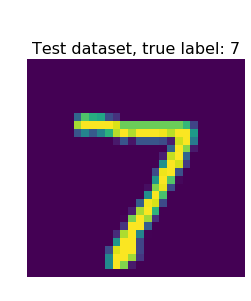

In [515]:
for i in range(1):
    show(x_test[i],'Test dataset, true label: '+str(np.argmax(y_test[i])))

### Test the model inference using gcloud locally

In [670]:
os.environ['CLOUDSDK_PYTHON']='/Users/tarrade/anaconda3/bin/python'

In [671]:
!gcloud ml-engine local predict --model-dir $MODEL_FOR_SERVING --json-instances ../data/input_predict_gcloud.json 

2019-02-07 14:47:57.372739: I tensorflow/core/common_runtime/process_util.cc:69] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.

DENSE_3
[5.820228579977993e-06, 2.2560351453648764e-07, 3.986712181358598e-05, 0.00012092345423297957, 1.6469396513230095e-08, 4.26365613748203e-06, 4.727720437358585e-10, 0.999786913394928, 7.320999429794028e-06, 3.4697757655521855e-05]
[1.374597104586428e-05, 0.004179574083536863, 0.9947308301925659, 0.0008424344123341143, 4.2751646667227305e-10, 0.00018749698938336223, 1.1633811482170131e-05, 2.49833398413557e-09, 3.442165325395763e-05, 7.398723300688914e-10]
[1.2485852494137362e-05, 0.9962553977966309, 0.000608675240073353, 0.0001076246626325883, 0.0008343913941644132, 0.00012625956151168793, 2.7262765797786415e-05, 0.0016017641173675656, 0.00036735867615789175, 5.882246477995068e-05]


### Deploy the model using Cloud ML Engine
- https://cloud.google.com/ml-engine/docs/v1/predict-request
- https://cloud.google.com/ml-engine/docs/tensorflow/online-predict#requesting_predictions

In [587]:
os.environ['PROJECT']=subprocess.run('gcloud config list project --format "value(core.project)"', shell=True, check=True, stdout=subprocess.PIPE).stdout.decode().replace('\n', '')
os.environ['MODEL']='mnist'
os.environ['BUCKET']='gs://'+os.environ['YOUR_PROJECT']
os.environ['VERSION']='v2'

In [581]:
# gsutil need python 2.7
os.environ['CLOUDSDK_PYTHON']='/Users/tarrade/anaconda/bin/python'

In [585]:
!gsutil cp -r $MODEL_FOR_SERVING $BUCKET/model_dir_tmp/

Copying file://../results/Models/Mnist/tf_1_12/estimator/pt/1549054852/saved_model.pb [Content-Type=application/octet-stream]...
Copying file://../results/Models/Mnist/tf_1_12/estimator/pt/1549054852/variables/variables.data-00000-of-00001 [Content-Type=application/octet-stream]...
Copying file://../results/Models/Mnist/tf_1_12/estimator/pt/1549054852/variables/variables.index [Content-Type=application/octet-stream]...
\ [3 files][  2.4 MiB/  2.4 MiB]                                                
Operation completed over 3 objects/2.4 MiB.                                      


In [592]:
!gcloud ml-engine models list

NAME   DEFAULT_VERSION_NAME
mnist  v1


when creating the model for the first time

create a version and store the model

In [595]:
!gcloud ml-engine versions create ${VERSION} \
--model ${MODEL} \
--origin=${BUCKET}/model_dir_tmp/1549054852 \
--runtime-version=1.12 \
--staging-bucket=${BUCKET}

ERROR: (gcloud.ml-engine.versions.create) ALREADY_EXISTS: Field: version.name Error: A version with the same name already exists.
- '@type': type.googleapis.com/google.rpc.BadRequest
  fieldViolations:
  - description: A version with the same name already exists.
    field: version.name


#### Checking the list of model in ML-Engine

In [605]:
!gcloud ml-engine models list

NAME   DEFAULT_VERSION_NAME
mnist  v1


In [610]:
 !gcloud ml-engine versions list --model mnist

NAME  DEPLOYMENT_URI                                              STATE
v1    gs://ml-productive-pipeline-53122/model_dir_tmp/1549054852  READY
v2    gs://ml-productive-pipeline-53122/model_dir_tmp/1549054852  READY


#### Testing our model using ML-Engine

In [672]:
!gcloud ml-engine predict --model=${MODEL} --version=${VERSION} --json-instances ../data/input_predict_gcloud.json

DENSE_3
[5.820239039167063e-06, 2.2560371348845365e-07, 3.9867194573162124e-05, 0.00012092355609638616, 1.6469426711296364e-08, 4.263659775460837e-06, 4.727719882247072e-10, 0.9997867941856384, 7.321012162719853e-06, 3.4697819501161575e-05]
[1.3745981959800702e-05, 0.004179579671472311, 0.9947307109832764, 0.0008424347033724189, 4.275147735821605e-10, 0.00018749696027953178, 1.163381057267543e-05, 2.4983288771096568e-09, 3.442161687416956e-05, 7.39872219046589e-10]
[1.2485862498579081e-05, 0.9962552785873413, 0.0006086757639423013, 0.00010762474994407967, 0.0008343925583176315, 0.00012625991075765342, 2.7262842195341364e-05, 0.0016017662128433585, 0.0003673589671961963, 5.8822570281336084e-05]


#### Testing using RESTful API 
- https://www.tensorflow.org/serving/api_rest  
RESTful API is an application program interface (API) that uses HTTP requests to GET, PUT, POST and DELETE data (Json)

Use cURL

In [673]:
!curl https://ml.googleapis.com/v1/projects/${PROJECT}/models/${MODEL}/versions/${VERSION} \
-H "Authorization: Bearer $(gcloud auth print-access-token)" \

{
  "name": "projects/ml-productive-pipeline-53122/models/mnist/versions/v2",
  "deploymentUri": "gs://ml-productive-pipeline-53122/model_dir_tmp/1549054852",
  "createTime": "2019-02-07T11:00:51Z",
  "lastUseTime": "2019-02-07T13:48:20Z",
  "runtimeVersion": "1.12",
  "state": "READY",
  "etag": "KoHdxAqPbTQ=",
  "framework": "TENSORFLOW",
  "machineType": "mls1-c1-m2",
  "pythonVersion": "2.7"
}


In [674]:
!curl -X POST \
https://ml.googleapis.com/v1/projects/${PROJECT}/models/${MODEL}/versions/${VERSION}:predict \
-H "Content-Type: application/json" \
-H "Authorization: Bearer $(gcloud auth print-access-token)" \
-d @../data/input_predict_cURL.json 

{"predictions": [{"dense_3": [1.2485862498579081e-05, 0.9962552785873413, 0.0006086757639423013, 0.00010762474994407967, 0.0008343925583176315, 0.00012625991075765342, 2.7262842195341364e-05, 0.0016017662128433585, 0.00036735893809236586, 5.8822570281336084e-05]}, {"dense_3": [1.2485862498579081e-05, 0.9962552785873413, 0.0006086757639423013, 0.00010762474994407967, 0.0008343925583176315, 0.00012625991075765342, 2.7262842195341364e-05, 0.0016017662128433585, 0.00036735893809236586, 5.8822570281336084e-05]}, {"dense_3": [1.2485862498579081e-05, 0.9962552785873413, 0.0006086757639423013, 0.00010762474994407967, 0.0008343925583176315, 0.00012625991075765342, 2.7262842195341364e-05, 0.0016017662128433585, 0.0003673589671961963, 5.8822570281336084e-05]}]}

Use python and requests

In [686]:
url = 'https://ml.googleapis.com/v1/projects/'+os.environ['PROJECT']+'/models/'+os.environ['MODEL']+'/versions/'+os.environ['VERSION']+':predict'

headers = {
    'Content-Type': 'application/json',
    'Authorization':  'Bearer {}'.format(subprocess.run('gcloud auth print-access-token', shell=True, check=True, stdout=subprocess.PIPE).stdout.decode().replace('\n', ''))}

json_response = requests.post(url=url, data=input_predict_request, headers=headers)
json.loads(json_response.text)

{'predictions': [{'dense_3': [5.820239039167063e-06,
    2.2560371348845365e-07,
    3.9867194573162124e-05,
    0.00012092355609638616,
    1.6469426711296364e-08,
    4.263659775460837e-06,
    4.727719882247072e-10,
    0.9997867941856384,
    7.321012162719853e-06,
    3.4697819501161575e-05]},
  {'dense_3': [1.3745981959800702e-05,
    0.004179579671472311,
    0.9947307109832764,
    0.0008424347033724189,
    4.275147735821605e-10,
    0.00018749696027953178,
    1.163381057267543e-05,
    2.4983288771096568e-09,
    3.442161687416956e-05,
    7.39872219046589e-10]},
  {'dense_3': [1.2485862498579081e-05,
    0.9962552785873413,
    0.0006086757639423013,
    0.00010762474994407967,
    0.0008343925583176315,
    0.00012625991075765342,
    2.7262842195341364e-05,
    0.0016017662128433585,
    0.0003673589671961963,
    5.8822570281336084e-05]}]}

In [687]:
predictions = json.loads(json_response.text)['predictions']

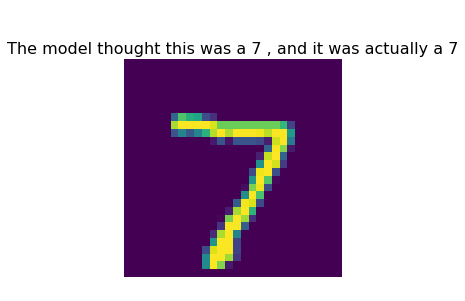

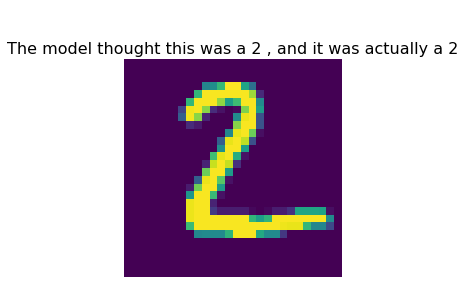

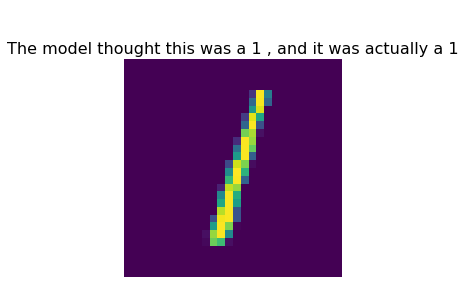

In [688]:
for i in range(0,3):
    show(x_test[i], 'The model thought this was a {} , and it was actually a {}'.format(np.argmax(predictions[i]['dense_3']),np.argmax(y_test[i])))

#### Testing using gRPC API 
- https://cloud.google.com/endpoints/docs/grpc/about-grpc  
gRPC is a high performance, open-source universal RPC framework, developed by Google. In gRPC, a client application can directly call methods on a server application on a different machine as if it was a local object, making it easier to create distributed applications and services (Protobuf)

In [552]:
# to do

## Debug Python environment

In [553]:
!python -c "import tensorflow as tf; print(tf.GIT_VERSION, tf.VERSION)"

b'unknown' 1.12.0


In [153]:
!conda list

# packages in environment at /Users/tarrade/anaconda3/envs/env_gcp_dl:
#
# Name                    Version                   Build  Channel
_tflow_select             2.3.0                       mkl  
absl-py                   0.7.0                    py36_0  
altair                    2.3.0                    pypi_0    pypi
appnope                   0.1.0            py36hf537a9a_0  
asn1crypto                0.24.0                   py36_0  
astor                     0.7.1                    py36_0  
astroid                   2.1.0                    py36_0  
atomicwrites              1.2.1                    py36_0  
attrs                     18.2.0           py36h28b3542_0  
autopep8                  1.4.3                    py36_0  
backcall                  0.1.0                    py36_0  
blas                      1.1                    openblas    conda-forge
bleach                    3.1.0                    pypi_0    pypi
c-ares                    1.15.0               h1de35cc